파이썬 머신러닝 완벽가이드 ch7. 3 ~ 4 (pg. 449~463)

---------------------
#07. 군집화 (Clustering)

####07-03. 평균 이동
- 평균 이동(Mean Shift)의 개요

####07-04. GMM (Gaussian Mixture Model)
- GMM 소개
- GMM을 이용한 붓꽃 데이터 세트 군집화
- GMM과 K-평균의 비교
---------

##07-03. 평균 이동
**평균 이동(Mean Shift)의 개요**
- 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동시켜서 군집 중심점으로 선정함.
- 주변 데이터와의 거리 값을 KDE 함수 값으로 입력 후 그 반환 값을 현재 위치에서 업데이트하면서 이동.
- 군집의 개수를 지정하지 않고 오직 대역폭의 크기에 따라 군집화를 수행.

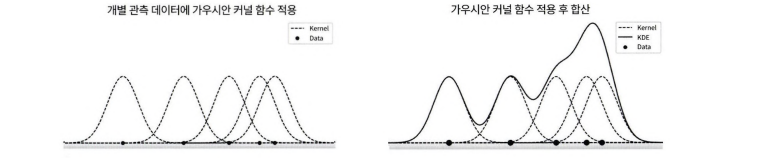

- KDE(Kernel Density Estimation)
   - 커널(Kernel) 함수를 통해 어떤 변수의 확률 밀도 함수(PDF, Probability Density Function)를 추정하는 대표적인 방법
   - 관측된 데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 데이터 건수로 나누어 PDF를 추정.
   - 대표적인 커널 함수는 가우시안 분포 함수.
   - KDE 함수식 (K:커널함수, x:확률 변수값, xi:관측값, h:대역폭)

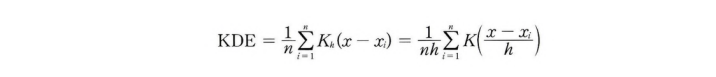

- 대역폭 h
   - KDE 형채를 부드러운(또는 뾰족한) 형태로 평활화(Smoothing)하는데 적용
   - KDE 형태의 뾰족함의 정도를 판단
   - 작은 h값 (h=1.0)
      - 좁고 뾰족한 KDE
      - 변동성이 큰 방식으로 pdf를 추정
      - 과적합(over-fitting)하기 쉬움.
      - 많은 수의 군집 중심점을 가짐.
   - 큰 h값 (h=10.0)
      - 과도하게 평활화(smoothing)된 KDE
      - 지나치게 단순화된 방식으로 pdf 추정
      - 과소적합(under-fitting)하기 쉬움.
      - 적은 수의 군집 중심점을 가짐.
   - 적절한 KDE의 대역폭 h를 계산하는 것은 KDE 기반의 평균 이동(Mean Shift) 군집화에서 매우 중요함.
      - 평균 이동 군집화는 오직 대역폭의 크기에 따라 군집화를 수행함.
      - 사이킷런은 최적의 대역폭 계산을 위해 estimate_bandwidth( )함수를 제공

         ```
from sklearn.cluster import estimate_bandwidth
```



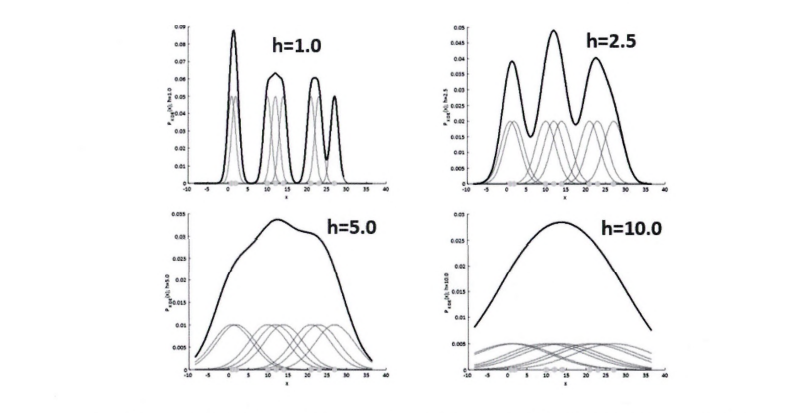

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)

## bandwidth=0.8이 너무 작게 설정되었는지 3개로 군집화 되어야할 것이 6개로 너무 세분화되어 군집화됨.
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [3]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)

## bandwidth=1일때 3개로 잘 군집화됨.
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [4]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)

## 최적의 bandwidth값은 1.816임.
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [5]:
# estimate_bandwidth()로 측정된 bandwidth를 평균 이동 입력값으로 적용해 동일한 make_blobs() 데이터 세트에 군집화 수행하기
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth를 계산
best_bandwidth = estimate_bandwidth(clusterDF)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(clusterDF)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


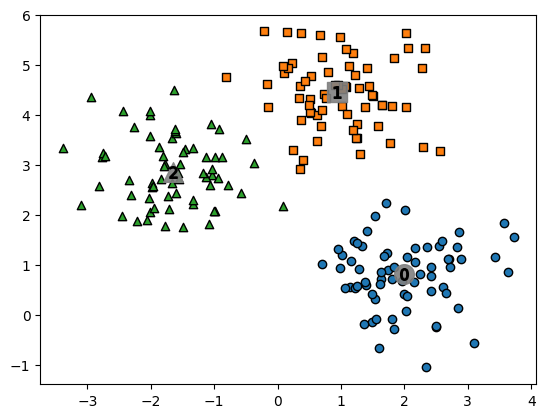

In [7]:
# 구성된 3개의 군집을 시각화하기
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  # 군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  # 군집별 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
plt.show()

In [8]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       1                  67
1       0                  67
2       2                  66
Name: count, dtype: int64


##07-04. GMM (Gaussian Mixture Model)
**GMM (Gaussian Mixture Model) 소개**
- 전체 데이터 세트는 서로 다른 정규분포 (가우시안 분포) 형태를 가진 여러가지 확률 분포 곡선으로 구성된다고 가정.
- 군집화 방식 : 모수 추정
   - 추정 대상  
      - 개별 정규 분포 찾기 (개별 정규 분포의 평균과 분산)
      - 데이터가 특정 정규 분포에 해당될 확률 찾기
   - 추정 방법 : EM(Expectation and Maximization)
- ```
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
```

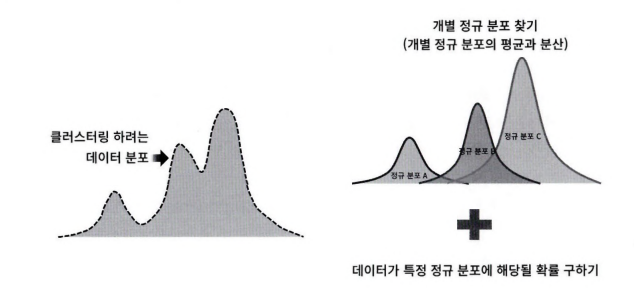

**GMM을 이용한 붓꽃 데이터 세트 군집화**

In [9]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 핸들링을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [10]:
# GMM 군집화 수행
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target값에 따라 gmm_cluster값이 어떻게 매핑되는지 확인
## GMM의 결과로 target1는 cluster0로 90%, cluster2로 10% 매핑됨.
iris_result = irisDF.groupby('target')['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [11]:
# KMeans 군집화 수행
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels

## KMeans의 결과로 target2가 cluster2로 72%, cluster0으로 28% 매핑됨.
## 붓꽃 데이터 세트엔 GMM이 더 효과적인듯.
iris_result = irisDF.groupby('target')['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


**GMM과 K-평균의 비교**
- K-평균 :
   - 거리 기반 군집화
   - 개별 군집 내의 데이터가 원형의 범위를 가질수록 군집화 효율이 높아짐.
      - 평균 거리 중심으로 중심을 이동하면서 군집화를 수행하기 때문임.
      - 원형의 범위로 퍼져 있지 않은 경우, 길쭉한 타원형같은 경우, 군집화 정확도가 매우 떨어짐.
      - make_blobs( )에서 cluster_std 파라미터를 작게 설정하면 데이터가 원형 형태로 분산됨.

- GMM :
   - 확률 기반 군집화
   - KMeans보다 유연하게 다양한 데이터 세트에서 군집화를 잘 수행함.
   - KMeans과 다르게 GaussianMixture 클래스는 cluster_centers_ 속성이 없으므로 군집의 좌표를 표시하지 않음.
   - 수행시간이 오래걸림.
- 군집 결과를 시각화하는 함수
```
   visualize_cluster_plot(clusterobj, dataframe, label_name, iscluster=True)
```
     - clusterobj : 군집 수행 객체. make_blobs( )로 만든 데이터의 시각화일 경우 None.
     - dataframe : 피처와 레이블 값을 가진 DataFrame
     - label_name : DataFrame 내의 군집화 레이블 칼럼명. make_blobs( )로 만든 데이터의 시각화일 경우 DataFrame 내의 타깃 칼럼명.
     - iscenter : 군집화 수행 객체가 중심 좌표를 제공하면 True, 안하면 False.

In [26]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
                        edgecolor='k', marker='$%d$' % label)

    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

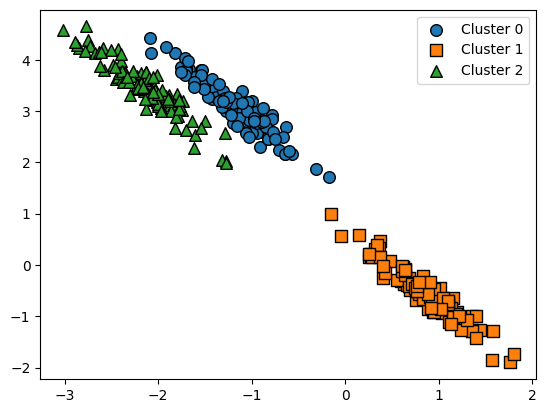

In [27]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개인 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해서 변환
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# 생성된 데이터 세트를 target별로 다른 마커로 표시하여 시각화
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

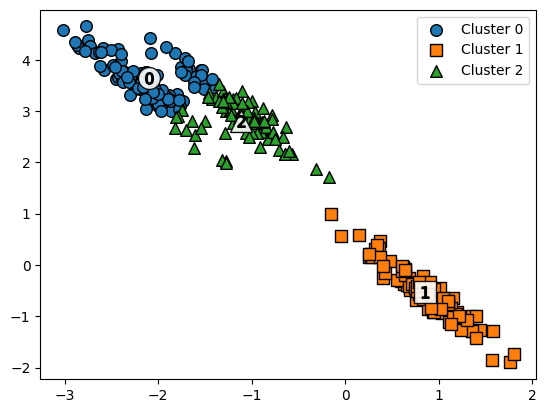

In [28]:
# 3개의 군집 기반 KMeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

## KMeans로 군집화 수행할 경우, 주로 원형 위치로 개별 군집화되면서 원하는 방향으로 구성되지 않음을 확인.
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

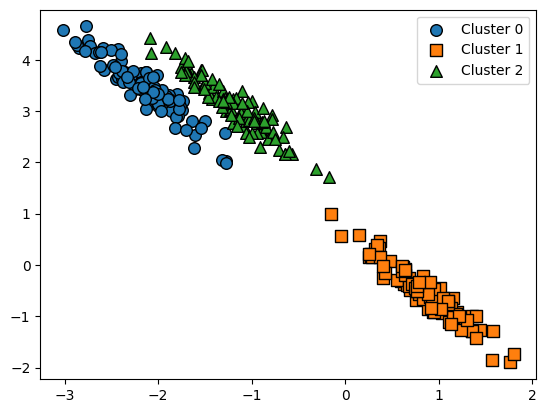

In [23]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit_predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture은 cluster_centers_ 속성이 없으므로 iscenter=False로 설정
## 데이터의 분포 방향에 따라 정확하게 군집화됨을 확인.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [24]:
## KMeans의 경우 cluster1만 정확히 매핑되었지만, 나머지 군집들의 경우 target값과 어긋나는 경우가 많이 발생함.
## GMM의 경우 모든 cluster이 모든 target에 정확히 매핑됨. 이처럼 GMM은 KMeans보다 유연하게 군집화가 가능.
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n ### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

 ### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
